In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
import sys

from matplotlib.gridspec import GridSpec

from numpy.polynomial.legendre import legval,legfit
import matplotlib as mpl
mpl.rcParams['font.size']=18
mpl.rcParams['font.serif'] = "Bitstream Vera Serif"
mpl.rcParams['font.family'] = "serif"



In [2]:
def filter_with_legPoly(cpsi,cor,max_deg):
    deg = range(0,max_deg,2)
    cor_legfit = np.zeros_like(cor)
    for ii in range(cor.shape[0]):
        x=cpsi[ii]
        cc=legfit(x,cor[ii],deg)
        cor_legfit[ii] = legval(x,cc)
    return cor_legfit

def leg_coefs(cpsi,cor,max_deg):
    deg = range(0,max_deg,2)
    coefs=[]
    for ii in range(cor.shape[0]):
        x=cpsi[ii]
        cc=legfit(x,cor[ii],deg)
        coefs.append(cc)
    return np.array(coefs)



def legfit_residual(cpsi,cor,max_deg):
    res=[]
    for mm in range(2,max_deg,2):
        fit = filter_with_legPoly(cpsi,cor,mm)
        res.append(np.abs(fit-cor))
    return np.array(res)

def legfit_residual2(cpsi,cor,max_deg):
    res=[]
    coefs =leg_coefs(cpsi,cor,max_deg)
    for mm in range(2,max_deg,2):
        cor_legfit = np.zeros_like(cor)
        for ii in range(cor.shape[0]):
            x=cpsi[ii]
            cor_legfit[ii] = legval(x,coefs[ii][:mm])
            
        res.append(np.abs(cor_legfit-cor))
    return np.array(res)


def filter_with_legPoly2(cpsi,cor,max_deg):
    
    cor_legfit = np.zeros_like(cor)
    for ii in range(cor.shape[0]):
        deg = range(0,max_deg[ii],2)
        x=cpsi[ii]
        cc=legfit(x,cor[ii],deg)
        cor_legfit[ii] = legval(x,cc)
    return cor_legfit

def normalize_cor(cor):
    x=cor-cor.min(-1)[:,None]
#     return x/x.max(-1)[:,None]
    return x/x.mean(-1)[:,None]
#
def symmetrize(diff):
    num_phi = diff.shape[-1]
    return 0.5*(diff[:,:num_phi/2]+diff[:,num_phi/2:])

In [4]:
f=h5py.File('/reg/d/psdm/cxi/cxilp6715/results/pca0_baseline/pca_remove_result.h5','r')
f0=h5py.File('/reg/d/psdm/cxi/cxilp6715/results/pca0_baseline/pca0_result.h5','r')


qvalues=np.load('/reg/neh/home/qiaoshen/notebooks/OE_figures/qvalues.npy')

In [5]:
num_phi = 354
phi_offset=15
exp_cpsi=np.load('/reg/neh/home/qiaoshen/notebooks/OE_figures/exp_cpsi.npy')[:,phi_offset:num_phi/2-phi_offset]

ALFdiff = symmetrize(f['ALF_diff'].value)[:,phi_offset:num_phi/2-phi_offset]
ALFerr = symmetrize(f['ALFdiff_err'].value)[:,phi_offset:num_phi/2-phi_offset]

GDPdiff = symmetrize(f['GDP_diff'].value)[:,phi_offset:num_phi/2-phi_offset]
GDPerr = symmetrize(f['GDPdiff_err'].value)[:,phi_offset:num_phi/2-phi_offset]

ALFdiff0 = symmetrize(f0['ALF_diff'].value)[:,phi_offset:num_phi/2-phi_offset]
ALFerr0 = symmetrize(f0['ALFdiff_err'].value)[:,phi_offset:num_phi/2-phi_offset]

GDPdiff0 = symmetrize(f0['GDP_diff'].value)[:,phi_offset:num_phi/2-phi_offset]
GDPerr0 = symmetrize(f0['GDPdiff_err'].value)[:,phi_offset:num_phi/2-phi_offset]

In [6]:
max_degree = 80
GDPres =legfit_residual(exp_cpsi,GDPdiff,max_deg=max_degree)/GDPerr
GDPres0 =legfit_residual(exp_cpsi,GDPdiff0,max_deg=max_degree)/GDPerr0

ALFres =legfit_residual(exp_cpsi,ALFdiff,max_deg=max_degree)/ALFerr
ALFres0 =legfit_residual(exp_cpsi,ALFdiff0,max_deg=max_degree)/ALFerr0

[78, 20, 8, 6, 6, 2, 4, 4, 2, 10, 4, 16, 16, 38, 32, 36, 76, 10, 22, 8, 6, 12, 34, 4, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2]


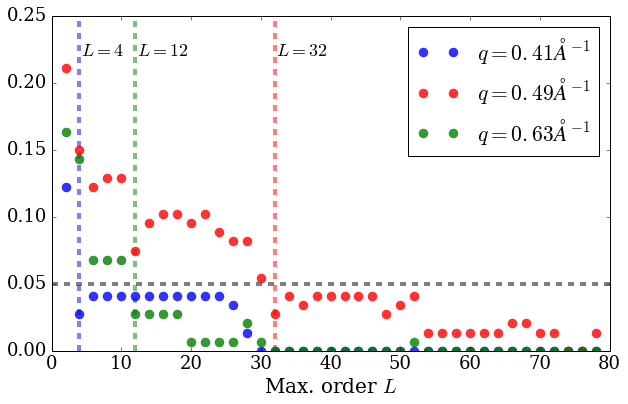

In [9]:
threshold=0.05
fit_quality = np.array([(GDPres[:,ii,:]>1).sum(-1)/float(GDPres.shape[-1]) for ii in range(35)])
inds = []
for ii in range(0,35):
    x=np.where(fit_quality[ii]>threshold)[0]
    if len(x)>0:
        xx = np.min([x[-1]+1,len(range(2,max_degree,2))-1])
        inds.append(range(2,max_degree,2)[xx])
    else:
        inds.append(range(2,max_degree,2)[0])
print inds

plt.figure(figsize=[10,6])
qinds = [10,14,21]
colors = ['b','r','g']
for ii,qidx in enumerate(qinds):
    plt.plot(range(2,max_degree,2),fit_quality[qidx,:],
            '.', markersize = 18, color=colors[ii], alpha=0.8
             , label='$q = %.2f \AA^{-1}$'% qvalues[qidx])
    plt.legend(loc='upper right')
plt.hlines(0.05,0,80, linewidth = 4, linestyle='--', alpha=0.5)
plt.xlabel('Max. order $L$', fontsize=20)
vlines = np.array(inds)[qinds]
for ii,vv in enumerate(vlines):
    plt.vlines(vv, 0,0.25, color=colors[ii],
               linestyle='--', alpha=0.5, linewidth=4)
    plt.text(s= '$L = %d$'%vv, x = vv+0.2,y=0.22)
plt.savefig('singal_maxL.png',bbox_inches='tight')

[76, 50, 62, 4, 78, 58, 50, 54, 24, 32, 78, 50, 78, 52, 78, 78, 78, 38, 78, 78, 78, 78, 78, 78, 78, 78, 56, 16, 74, 24, 78, 30, 78, 8, 8]


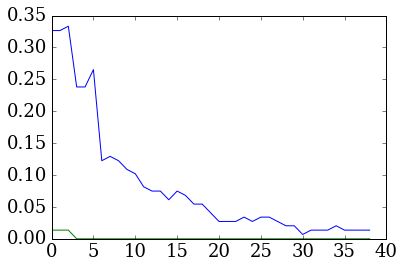

In [27]:

# plt.plot((ALFres[:,qidx,:]>1).sum(-1)/float(ALFres.shape[-1]))


fit_quality = np.array([(ALFres[:,ii,:]>1).sum(-1)/float(ALFres.shape[-1]) for ii in range(35)])
fit_quality0 = np.array([(ALFres0[:,ii,:]>1).sum(-1)/float(ALFres.shape[-1]) for ii in range(35)])
qidx =17
plt.plot(fit_quality[qidx,:])
plt.plot(fit_quality0[qidx,:])
# fit_quality0
np.where(fit_quality[qidx]>0.05)[0][-1]
inds=[]
for ii in range(0,35):
    x=np.where(fit_quality[ii]>threshold)[0]
    if len(x)>0:
        inds.append(range(2,max_degree,2)[x[-1]])
    else:
        inds.append(range(2,max_degree,2)[0])
print inds
# np.save('ALF_legfit_lmax.npy',np.array(inds))